In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import uuid
import itertools
import json
from frgpascal.experimentaldesign.recipes import SolutionRecipe, SpincoatRecipe, AnnealRecipe, Sample, from_json
from frgpascal.experimentaldesign.helpers import components_to_name
from copy import deepcopy

# Helper Functions

In [2]:
def generate_unique_id():
    return str(uuid.uuid4())

# Placeholder Workflow

In [3]:
def build_sample_list(input_substrates, target_solutions, spincoat_recipes, anneal_recipes, n_repeats=1):
    """
    Permutes experimental mesh into sample list
    """
    sample_list = []
    
    for idx, (sub, sol, sc, an) in enumerate(itertools.product(input_substrates, target_solutions, spincoat_recipes, anneal_recipes)):
        # recipe_id = generate_unique_id()
        sc_ = deepcopy(sc)
        sc_.solution = sol
        
        for r in range(n_repeats):
            sample_list.append(Sample(
                name=f'sample{idx}',
                substrate=sub,
                spincoat_recipe=sc_,
                anneal_recipe=an,
                # sampleid=sampleid
            ))
            
    return sample_list

In [4]:
def suggest_stock_solutions(target_solutions):
    """
    suggests smallest number of stock solutions required to cover the
    target solution space
    """
    
    return stock_solutions

In [5]:
from scipy.optimize import nnls

def calculate_mix(target: SolutionRecipe, volume: float, stock_solutions: list, tolerance:float =0.05):
    """
    given a target solution, target volume, and list of stock solutions, calculates
    the volumes needed from individual stocks to achieve target composition

    tolerance (float): maximum error for single site (relative, not absolute) allowed.
    
    """        
    # get possible solution components from stock list
    components = set()
    for s in stock_solutions:
        components.update(s.solute_dict.keys(), s.solvent_dict.keys())
    components = list(components) #sets are not order-preserving, lists are - just safer this way

    # organize components into a stock matrix, keep track of which rows are solvents
    stock_matrix = np.zeros((len(components), len(stock_solutions)))
    solvent_idx = set()
    for n, s in enumerate(stock_solutions):
        for m, c in enumerate(components):
            if c in s.solute_dict: 
                stock_matrix[m,n] = s.solute_dict[c]*s.molarity
            elif c in s.solvent_dict:
                stock_matrix[m,n] = s.solvent_dict[c]
                solvent_idx.add(m)
    solvent_idx = list(solvent_idx)

    # organize target solution into a matrix of total mols desired of each component 
    target_matrix = np.zeros((len(components),))
    for m, c in enumerate(components):
        if c in target.solute_dict: 
            target_matrix[m] = target.solute_dict[c]*target.molarity*volume
        elif c in target.solvent_dict:
            target_matrix[m] = target.solvent_dict[c]*volume

    # solve for the mixture amounts
    amount_matrix, *data = nnls(stock_matrix, target_matrix, maxiter=1e3) #volumes to mix. math is better if not such small values in matrix, so scale to uL for calculation
    amount_matrix[amount_matrix < 1] = 0 #clean up values that are essentially 0. If we have a significant negative value here, should get caught downstream
    amount_matrix = np.round(amount_matrix) #round to nearest uL (values are in L at this point)

    # double check that the solved amounts make sense
    doublecheck = stock_matrix @ amount_matrix
    doublecheck[solvent_idx] /= doublecheck[solvent_idx].sum() / volume #solvents should sum to one
    # print(stock_matrix)
    # print(amount_matrix)
    # print(target_matrix)
    composition_error = max([np.abs(1-c/t) for c,t in zip(doublecheck, target_matrix) if t>0]) #max single-component error fraction

    if composition_error < 0.05: #check that we are within 5% error wrt target composition AT EACH SITE
        return amount_matrix
    else:
        solute = components_to_name({c:amt/target.molarity/volume for c,amt in zip(components, doublecheck) if amt > 0 and c not in target.solvent_dict})
        solvent = components_to_name({c:amt/target.molarity/volume for c,amt in zip(components, doublecheck) if amt > 0 and c in target.solvent_dict})
        # print(solvent)
        raise Exception(f'Unable to generate target solution ({volume} uL of {target}) with current stock solutions.\n\n'\
                        f'Closest match ({volume} uL of {target.molarity}M {solute} in {solvent}) has a max site error of {composition_error*100:.2f}%')#{Off by {composition_error*100:.2f}%%')

In [6]:
def build_solution_library(sample_list, stock_solutions):
    """
    finds volume required for each unique solution
    assigns a (labware, well) per solution
    generates a mixing netlist for liquid handler to convert stocks to mixed solutions
    """
    return solution_map, lh_netlist

In [7]:
def finalize_sample_list(sample_list, solution_map):
    """
    assigns the storage slots (tray, slot) and solution sources (labware, well)
    to each sample.
    """
    return final_sample_list, tray_list

## Generate Example Recipes

In [8]:
input_substrates = [
    '1mm_FTO'
]

In [9]:
target_solutions = [
    SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA0.25_MA0.75_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA0.75_MA0.25_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='MA0.5_FA0.5_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
]

In [10]:
cb_antisolvent = SolutionRecipe(
            solutes='',
            solvent='Chlorobenzene',
            molarity=1
        )
ma_antisolvent = SolutionRecipe(
            solutes='',
            solvent='MethylAcetate',
            molarity=1
        )


In [11]:
spincoat_recipes = [
    SpincoatRecipe(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        solution_volume=100, #uL
        solution_droptime=-5, #seconds relative to start time
        antisolvent=cb_antisolvent,
        antisolvent_volume=50, #seconds relative to start time
        antisolvent_droptime=40,
    ),
    SpincoatRecipe(
        steps=[
            [500,1000,20],
            [4000,4000,30]
        ],
        solution_volume=100, #uL
        solution_droptime=-5,
        antisolvent=cb_antisolvent,
        antisolvent_volume=50,
        antisolvent_droptime=45,
    ),
]


In [12]:
anneal_recipes = [
    AnnealRecipe(
        temperature=100, #degrees C
        duration=60*10, #seconds
    ),
    AnnealRecipe(
        temperature=120, #degrees C
        duration=60*7.5, #seconds
    ),
    AnnealRecipe(
        temperature=140, #degrees C
        duration=60*5, #seconds
    ),
]

In [14]:
samples = build_sample_list(
    input_substrates = input_substrates,
    target_solutions = target_solutions,
    spincoat_recipes=spincoat_recipes,
    anneal_recipes=anneal_recipes,
    n_repeats=2
)
unique_solutions = list(set(
    [s.spincoat_recipe.solution for s in samples]
    + [s.spincoat_recipe.antisolvent for s in samples]))

print(f'{len(unique_solutions)} unique solutions required across {len(samples)} planned samples')

6 unique solutions required across 60 planned samples


## Define Stock Solutions

In [15]:
stock_solutions = [
    SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='DMF',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='DMSO',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='MethylAcetate',
        molarity=1
    ),
]

Can we cover target solutions with these stocks? and if so, how much of each stock to mix for each target?

In [16]:
min_volume = 0
solution_details = {s:dict(volume=min_volume, labware=None, slot=None) for s in unique_solutions}
for s in samples:
    for sol in [s.spincoat_recipe.solution, s.spincoat_recipe.antisolvent]:
        if sol is not None:
            solution_details[sol]['volume'] += s.spincoat_recipe.solution_volume
    

In [17]:
mixtures = np.array([
    calculate_mix(
        target=solution,
        volume=v['volume'],
        stock_solutions = stock_solutions
    ) for solution, v in solution_details.items()])

In [19]:
volumes_needed_per_stock = mixtures.sum(axis=0)
for s, v in zip(stock_solutions, volumes_needed_per_stock):
    if v > 0:
        print(f'{v/1e3} mL of {s}')

3.0 mL of <SolutionRecipe> 1M MA_Pb_I3 in DMF9_DMSO1
3.0 mL of <SolutionRecipe> 1M FA_Pb_I3 in DMF9_DMSO1
6.0 mL of <SolutionRecipe> Chlorobenzene


Which solutions need to be made from stocks?

In [20]:
to_be_mixed = {s:v for s,v in solution_details.items() if s not in stock_solutions}

What vessel do we need to put everything in? depends on required volumes

In [25]:
class LiquidLabware:
    def __init__(self, name, volume, numx, numy):
        if '-' in name:
            raise ValueError(' "-" character not allowed in LiquidLabware name')
        self.name = name
        self.volume = volume 
        self.shape = (numy, numx)
        self.capacity = numx * numy
        self.contents = {}
        self.__generate_coordinates()
        self.__index = 0

    def load(self, content):
        try:
            slot = self._openslots.pop(0)   
            self.contents[slot] = content
            return slot 
        except IndexError as e:
            raise IndexError('This labware is full!')

    def __generate_coordinates(self):
        def letter(num):
            # converts number (0-25) to letter (A-Z)
            return chr(ord("A") + num)

        self._openslots = []
        ycoords = [
            letter(self.shape[1] - yidx - 1) for yidx in range(self.shape[1])
        ]  # lettering +y -> -y = A -> Z

        for yidx in ycoords[::-1]:  # y
            for xidx in range(self.shape[0]): # x
                name = f"{yidx}{xidx+1}"
                self._openslots.append(name)

    def __repr__(self):
        out = f'<LiquidLabware> {self.name}, {self.volume/1e3} mL volume, {self.capacity} wells'
        return out

In [49]:
solution_storage = [
    LiquidLabware(
        name='96_Plate1',
        volume=200,
        numx=12,
        numy=8
    ),
    LiquidLabware(
        name='96_Plate2',
        volume=200,
        numx=12,
        numy=8
    ),
    LiquidLabware(
        name='4mL_Tray1',
        volume=4000,
        numx=6,
        numy=4
    ),

    LiquidLabware(
        name='4mL_Tray2',
        volume=4000,
        numx=6,
        numy=4
    ),
    LiquidLabware(
        name='15mL_Tray1',
        volume=15000,
        numx=4,
        numy=3
    ),
    LiquidLabware(
        name='15m_Tray2',
        volume=15000,
        numx=4,
        numy=3
    ),
]

#sort by volume,name
solution_storage.sort(key=lambda labware: labware.name)
solution_storage.sort(key=lambda labware: labware.volume)
print('Priority Fill Order:')
for ss in solution_storage: print(ss)

Priority Fill Order:
<LiquidLabware> 96_Plate1, 0.2 mL volume, 96 wells
<LiquidLabware> 96_Plate2, 0.2 mL volume, 96 wells
<LiquidLabware> 4mL_Tray1, 4.0 mL volume, 24 wells
<LiquidLabware> 4mL_Tray2, 4.0 mL volume, 24 wells
<LiquidLabware> 15mL_Tray1, 15.0 mL volume, 12 wells
<LiquidLabware> 15m_Tray2, 15.0 mL volume, 12 wells


In [50]:
def where_to_store(volume, options):
    for ll in options:
        if volume <= ll.volume and len(ll._openslots) > 0:
            return ll
    raise ValueError(f'No options have enough space to hold {volume/1e3:.2f} mL!')



In [51]:
for solution, v in solution_details.items():
    ll = where_to_store(v['volume'], solution_storage) #which liquid labware
    slot = ll.load(solution)
    solution_details[solution]['labware'] = ll.name
    solution_details[solution]['slot'] = slot

In [52]:
solution_details

{<SolutionRecipe> 1M MA_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A1'},
 <SolutionRecipe> 1M MA0.5_FA0.5_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A2'},
 <SolutionRecipe> 1M FA0.75_MA0.25_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A3'},
 <SolutionRecipe> 1M FA_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A4'},
 <SolutionRecipe> Chlorobenzene: {'volume': 6000,
  'labware': '15mL_Tray1',
  'slot': 'A1'},
 <SolutionRecipe> 1M FA0.25_MA0.75_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'B1'}}

Set up the mixing netlist for liquid handler

In [53]:
mixing_netlist = {} #destination: {source, volume}

for target, target_v in solution_details.items():
    if target in stock_solutions:
        continue #stock solution is already made
    destination = f"{target_v['labware']}-{target_v['slot']}"
    mixing_netlist[destination] = {}
    required_volumes = calculate_mix(
        target=target,
        volume=target_v['volume'],
        stock_solutions = stock_solutions
    )
    for stock, vol in zip(stock_solutions, required_volumes):
        if vol > 0:    
            stock_v = solution_details[stock]
            source = f"{stock_v['labware']}-{stock_v['slot']}"
            mixing_netlist[destination][source]=vol
            


Set up the sample instructions using specific labware/slots

In [77]:
class Worker:
    def __init__(self, name, capacity):
        self.name = name
        self.capacity = capacity

    def __repr__(self):
        return f'<Worker> {self.name}'

In [87]:
gg = Worker(name='gantry_gripper', capacity=1)
sclh = Worker(name='spincoater_liquidhander', capacity=1)
hp = Worker(name='hotplate', capacity=25)
st = Worker(name='storage', capacity=45)
cl = Worker(name='characterizationline', capacity=1)

workers = [gg,sclh,hp,st,cl]
workers

[<Worker> gantry_gripper,
 <Worker> spincoater_liquidhander,
 <Worker> hotplate,
 <Worker> storage,
 <Worker> characterizationline]

In [191]:
class Task:
    def __init__(self, sample, task, workers, duration, start_time = 0, task_details = '', precedents=[]):
        self.sample=sample
        self.workers = workers
        self.task = task
        self.task_details = task_details
        self.taskid = f'{task}-{str(uuid.uuid4())}'
        self.precedentids = precedents
        self.duration = int(duration)
        self.start_time = start_time

    def __repr__(self):
        return f'<Task> {self.sample.name}, {self.task}'
    @property
    def start_time(self):
        return self.__start_time

    @start_time.setter
    def start_time(self, t):
        self.__start_time = int(t)
        self.end_time = int(t+self.duration)

    def __eq__(self, other):
        return other==self.taskid


class StorageToSpincoater(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='storage_to_spincoater',
            workers=[gg, sclh],
            duration=30,
            precedents = precedents,
            start_time = start_time
            )
class Spincoat(Task):
    def __init__(self, sample, recipe:SpincoatRecipe, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='spincoat',
            workers=[sclh],
            duration=recipe.duration + 45,
            task_details=recipe.to_json(),
            precedents = precedents,
            start_time = start_time
            )
class SpincoaterToHotplate(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='spincoater_to_hotplate',
            workers=[gg, sclh],
            duration= 30,
            precedents = precedents,
            start_time = start_time
            )
class Anneal(Task):
    def __init__(self, sample, recipe:AnnealRecipe, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='anneal',
            workers=[hp],
            duration=recipe.duration,
            task_details=recipe.to_json(),
            precedents = precedents,
            start_time = start_time
            )
class HotplateToStorage(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='hot',
            workers=[gg],
            duration= 30,
            precedents = precedents,
            start_time = start_time
            )
class Cooldown(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='cooldown',
            workers=[st],
            duration= 180,
            precedents = precedents,
            start_time = start_time
            )
class StorageToCharacterization(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='storage_to_characterization',
            workers=[gg, cl],
            duration= 30,
            precedents = precedents,
            start_time = start_time
            )
class Characterize(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='characterize',
            workers=[cl],
            duration= 120,
            precedents = precedents,
            start_time = start_time
            )
class CharacterizationToStorage(Task):
    def __init__(self, sample, tray, slot, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='characterization_to_storage',
            workers=[gg, cl],
            duration= 30,
            precedents = precedents,
            start_time = start_time
            )

In [192]:
def generate_tasks_for_sample(sample: Sample, start_time = 0):
    tasks = []
    tasks.append(StorageToSpincoater(sample=sample, start_time=start_time))
    tasks.append(Spincoat(sample=sample, recipe=sample.spincoat_recipe, start_time = tasks[-1].end_time))
    tasks.append(SpincoaterToHotplate(sample=sample, start_time = tasks[-1].end_time))
    tasks.append(Anneal(sample=sample, recipe = sample.anneal_recipe, start_time = tasks[-1].end_time))
    tasks.append(HotplateToStorage(sample=sample, start_time = tasks[-1].end_time))
    tasks.append(Cooldown(sample=sample, start_time = tasks[-1].end_time))
    tasks.append(StorageToCharacterization(sample=sample, start_time = tasks[-1].end_time))
    tasks.append(Characterize(sample=sample, start_time = tasks[-1].end_time))
    tasks.append(SpincoaterToHotplate(sample=sample, start_time = tasks[-1].end_time))
    return tasks

In [193]:
tasks = collections.OrderedDict({s:generate_tasks_for_sample(s) for s in samples})

In [213]:
from ortools.sat.python import cp_model

class Scheduler:
    def __init__(self, workers, tasks):
        self.workers = workers
        self.tasks = tasks
        self.tasklist = [t
            for sample_tasks in tasks.values()
            for t in sample_tasks]
        self.horizon = int(sum([
            t.duration for t in self.tasklist]))
        self.initialize_model()


    def initialize_model(self):
        self.model = cp_model.CpModel()
        ending_variables = []
        machine_intervals = {w:[] for w in self.workers}
        ### Task Constraints
        for sample, tasklist in self.tasks.items():
            for i, task in enumerate(tasklist):
                if i == 0:
                    start_var = self.model.NewIntVar(task.start_time, self.horizon, "start"+str(task))
                else:
                    start_var = end_var
                end_var = self.model.NewIntVar(task.end_time, self.horizon, "end"+str(task))
                interval_var = self.model.NewIntervalVar(start_var, task.duration, end_var, "interval"+str(task))
                for w in task.workers:
                    machine_intervals[w].append(interval_var)
                task._start = start_var
                task._interval = interval_var
                task._end = end_var
            ending_variables.append(end_var)
            

        ### Worker Constraints
        for w in workers:
            intervals = machine_intervals[w]
            if w.capacity > 1:
                demands = [1 for _ in machine_intervals[w]]
                self.model.AddCumulative(intervals, demands, w.capacity)
            else:
                self.model.AddNoOverlap(intervals)
        objective_var = self.model.NewIntVar(0,self.horizon, 'makespan')
        self.model.AddMaxEquality(objective_var, ending_variables)
        self.model.Minimize(objective_var)

    def solve(self, solve_time = 5):
        self.solver = cp_model.CpSolver()
        self.solver.parameters.max_time_in_seconds = solve_time
        status = self.solver.Solve(self.model)

    # def _set_start_time(self, task):
    #     for pid in task.precedents:
    #         ptidx = self.tasks.index(pid)
    #         pt = self.tasks[ptidx]
    #         if pt.end_time < task.start_time:
    #             task.start_time = pt.end_time



In [234]:
scheduler = Scheduler(
    workers=workers,
    tasks=tasks
)

In [235]:
scheduler.solve(30)

Text(0.5, 0, 'Time (minutes)')

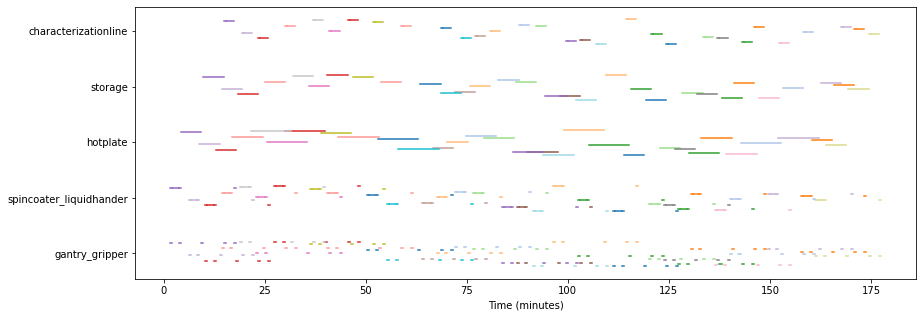

In [236]:
plt.figure(figsize=(14,5))

for idx, (sample, tasklist) in enumerate(scheduler.tasks.items()):
    color = plt.cm.tab20(idx%20)
    offset = np.random.random()*0.5 - 0.25
    for t in tasklist:
        for w in t.workers:
            y = [scheduler.workers.index(w) + offset]*2
            x = [scheduler.solver.Value(t._start)/60, scheduler.solver.Value(t._end)/60]
            plt.plot(x,y, color=color)

plt.yticks(range(len(scheduler.workers)), labels=[w.name for w in scheduler.workers])
plt.xlabel('Time (minutes)')

        

In [230]:
scheduler.

SyntaxError: invalid syntax (<ipython-input-230-c155ac0a68ca>, line 1)

In [ ]:
plt.figure(figsize=(14,5))

# Create one list of assigned tasks per machine.
assigned_jobs = collections.defaultdict(list)
for job_id, job in jobs_data.items():
    for task_id, task in job.items():
        for machine in task[0]:
            assigned_jobs[machine].append(
                assigned_task_type(
                    start=solver.Value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task.duration))

# Create per machine output lines.
for machine in machines:
    # Sort by starting time.
    assigned_jobs[machine].sort()
    for assigned_task in assigned_jobs[machine]:
        myval = machines.index(machine) + np.random.random()*0.2 - 0.1
        plt.plot([assigned_task.start/60, (assigned_task.start+assigned_task.duration)/60], [myval, myval],
                marker='o',markersize=1, color=plt.cm.tab10(int(assigned_task.job.replace('sample', ''))%10))

plt.yticks(range(len(machines)), labels=machines)
plt.xlabel('Minutes')
plt.title(f'{len(samples)} Samples, {solver.ObjectiveValue()/3600:.1f} Hours')
# Finally print the solution found.
print(f'Optimal Schedule Length: {solver.ObjectiveValue()/60} minutes')
# print(output)
# plt.xlim(0, 60)

In [ ]:
def build_instructions_for_sample(sample, )

# Write final files to disk

## Write mixing netlist to disk, will be copy-pasted into listener.py protocol

In [24]:
with open('netlist.json', 'w') as f:
    json.dump(mixing_netlist, f)
print('Liquid Handler Netlist String dumped to "netlist.json"')

Liquid Handler Netlist String dumped to "netlist.json"
